# FENE beadspring with variable kuhn length experiment data analysis

In [67]:
import os

import plotly.colors

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.data_analysis.data.constants as data_constants
import polyflexmd.data_analysis.pipelines.trajectory as pipeline_process
import polyflexmd.experiment_runner.config as config
import polyflexmd.data_analysis.plot.msd
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns
import scipy.optimize
import functools

import matplotlib.transforms

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
sns.set_style("darkgrid")

sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=BIGGER_SIZE)  # fontsize of the figure title


## Read and process data

In [9]:
PATH_EXPERIMENT = "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/538accb2"
NAME_EC = "4-FENE-beadspring-vary-l_K.toml"
EQUILIBRIUM_ONLY = True
CONTINUE = False
CONTINUE_t_equilibrium = 58000000
N_WORKERS = 16
CHECK_BOND_LENGTHS = False

In [10]:
CONTINUE = bool(CONTINUE)
CONTINUE_t_equilibrium = int(CONTINUE_t_equilibrium)
EQUILIBRIUM_ONLY = bool(EQUILIBRIUM_ONLY)
CHECK_BOND_LENGTHS = bool(CHECK_BOND_LENGTHS)
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC
N_WORKERS = int(N_WORKERS)

### Read experiment config

In [11]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='96:00:00', partition='romeo', nodes=8, tasks_per_node=125, ntasks=1000, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results'), n_partitions=8, n_tasks_per_partition=125, variables={'kappa_start': 1.0, 'kappa_delta': 10, 'kappa_n_values': 8, 'n_relax_steps': 30000000, 'n_equilibrium_steps_1': 2000000, 'dump_frequency_1': 100, 'n_equilibrium_steps_2': 33000000, 'dump_frequency_2': 10000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=

In [12]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[1.0, 11.0, 21.0, 31.0, 41.0, 51.0, 61.0, 71.0]

### Read initial system

In [13]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

molecule-ID  type          x          y         z  ix  iy  iz
1                1     1   0.000000   0.000000  0.000000   0   0   0
2                1     1  -0.336178   0.186169  0.890632   0   0   0
3                1     2  -0.672356   0.372339  1.781264   0   0   0
4                1     2  -1.008534   0.558508  2.671896   0   0   0
5                1     2  -1.344712   0.744678  3.562528   0   0   0
...            ...   ...        ...        ...       ...  ..  ..  ..
31996          500     2  25.290807 -50.942120 -6.367762   0   0   0
31997          500     2  25.719465 -51.805546 -6.475690   0   0   0
31998          500     2  26.148122 -52.668972 -6.583618   0   0   0
31999          500     2  26.576780 -53.532397 -6.691547   0   0   0
32000          500     3  27.005438 -54.395823 -6.799475   0   0   0

[32000 rows x 8 columns]

In [14]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Read main-axis dataframe

In [15]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
if CONTINUE:
    PATH_DATA_PROCESSED = PATH_DATA_PROCESSED / "continue"
PATH_DATA_PROCESSED

PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/538accb2/data/processed')

In [16]:
PATH_DF_MAIN_AXIS = PATH_DATA_PROCESSED / "main_axis.csv"
df_main_axis = pd.read_csv(PATH_DF_MAIN_AXIS).groupby("molecule-ID").nth(1)
df_main_axis

molecule-ID  type         x         y         z  ix  iy  iz
1              1     1 -0.336178  0.186169  0.890632   0   0   0
3              2     1 -0.272215 -0.119898  0.923268   0   0   0
5              3     1 -0.517323 -0.532615 -0.624178   0   0   0
7              4     1  0.302546 -0.396453  0.831980   0   0   0
9              5     1 -0.592061  0.192979  0.743722   0   0   0
..           ...   ...       ...       ...       ...  ..  ..  ..
991          496     1  0.301950 -0.674609 -0.628195   0   0   0
993          497     1 -0.010688  0.215110 -0.945787   0   0   0
995          498     1 -0.072238  0.104175  0.961680   0   0   0
997          499     1 -0.396090 -0.883587  0.057330   0   0   0
999          500     1  0.428658 -0.863426 -0.107928   0   0   0

[500 rows x 8 columns]

## Calculate and plot observables

In [17]:
l_b_src = .97
L_src = l_b_src * (conf.initial_system_config.system_config.n_monomers - 1)
L_src

61.11

### Color palette

In [18]:
kappa_colors = sns.color_palette("viridis", n_colors=len(kappas))
kappa_colors

[(0.281412, 0.155834, 0.469201),
 (0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476),
 (0.709898, 0.868751, 0.169257)]

### End-to-End distance $\vec{R}$

In [19]:
PATH_ETE = PATH_DATA_PROCESSED / "ete.csv"
df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "molecule-ID", "t"])
df_ete

R_x       R_y        R_z          R
kappa molecule-ID t                                                  
1.0   1           30000000   4.653390   7.51274   7.235560  11.421411
      2           30000000   5.183050   2.47633   9.489370  11.092537
      3           30000000   4.879620  -1.24165   8.614230   9.977843
      4           30000000   0.573486  -4.00533   3.909040   5.626024
      5           30000000  -2.084040  -6.83918   0.227633   7.153281
...                               ...       ...        ...        ...
71.0  496         65000000  32.172900 -46.69850 -10.628500  57.695847
      497         65000000  19.717800  37.38680 -38.115400  56.915268
      498         65000000 -42.031100  -7.32022  25.061500  49.480076
      499         65000000 -25.478400 -50.98580  15.163900  58.980034
      500         65000000  46.443500 -29.78540   7.322810  55.657818

[93204000 rows x 4 columns]

In [20]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x       R_y        R_z          R  \
kappa molecule-ID t                                                     
1.0   1           30000000   4.653390   7.51274   7.235560  11.421411   
      2           30000000   5.183050   2.47633   9.489370  11.092537   
      3           30000000   4.879620  -1.24165   8.614230   9.977843   
      4           30000000   0.573486  -4.00533   3.909040   5.626024   
      5           30000000  -2.084040  -6.83918   0.227633   7.153281   
...                               ...       ...        ...        ...   
71.0  496         65000000  32.172900 -46.69850 -10.628500  57.695847   
      497         65000000  19.717800  37.38680 -38.115400  56.915268   
      498         65000000 -42.031100  -7.32022  25.061500  49.480076   
      499         65000000 -25.478400 -50.98580  15.163900  58.980034   
      500         65000000  46.443500 -29.78540   7.322810  55.657818   

                                t/LJ          R^2  
kappa molecule-ID t                                
1.0   1           30000000   75000.0   130.448641  
      2           30000000   75000.0   123.044377  
      3           30000000   75000.0    99.557351  
      4           30000000   75000.0    31.652148  
      5           30000000   75000.0    51.169425  
...                              ...          ...  
71.0  496         65000000  162500.0  3328.810761  
      497         65000000  162500.0  3239.347732  
      498         65000000  162500.0  2448.277921  
      499         65000000  162500.0  3478.644411  
      500         65000000  162500.0  3097.792705  

[93204000 rows x 6 columns]

In [21]:
df_ete_mean = df_ete.groupby(["kappa", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa")),
    l_b=l_b_src
)
df_ete_mean

R^2         l_K
kappa t                                
1.0   30000000   121.753577    1.854017
      30000100   122.022246    1.854017
      30000200   122.315529    1.854017
      30000300   122.462672    1.854017
      30000400   122.593975    1.854017
...                     ...         ...
71.0  64960000  2825.152344  136.770000
      64970000  2824.566295  136.770000
      64980000  2816.356893  136.770000
      64990000  2804.853668  136.770000
      65000000  2797.986697  136.770000

[186408 rows x 2 columns]

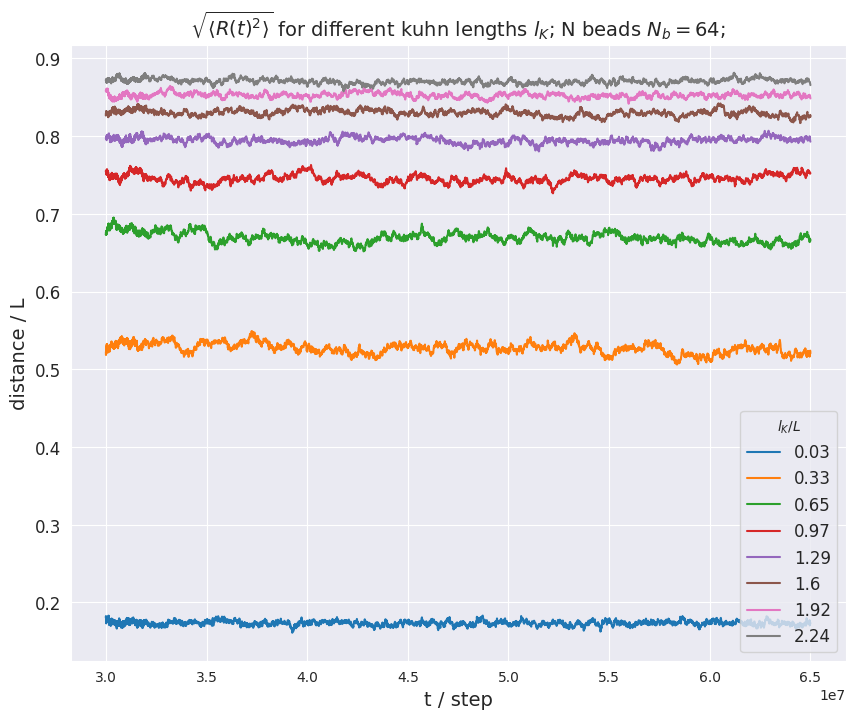

In [22]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10, 8))

ax.set(
    title=f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.initial_system_config.system_config.n_monomers}$;',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_mean.index.get_level_values("t"),
    y=np.sqrt(df_ete_mean["R^2"]) / L_src,
    hue=(df_ete_mean["l_K"] / L_src).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Equilibrium statistics

In [23]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"] if not CONTINUE else CONTINUE_t_equilibrium
t_equilibrium

30000000

### Mean bond length

In [24]:
l_b = conf.initial_system_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [25]:
L_contour = l_b * (conf.initial_system_config.system_config.n_monomers - 1)
L_contour

61.11

### Kuhn lengths

Svaneborg (8)

In [26]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([  1.85401695,  20.37000013,  39.77      ,  59.17      ,
        78.57      ,  97.97      , 117.37      , 136.77      ])

Estimate from fit (Worm-like chain model, Hinczewski):

In [27]:
PATH_L_K_ESTIMATE = PATH_DATA_PROCESSED / "l_K-estimate.csv"
l_ks_estimate = pd.read_csv(PATH_L_K_ESTIMATE, index_col="kappa")
l_ks_estimate

t         l_K     d_l_K
kappa                                
1.0    30000000    1.686888  0.026178
11.0   30000000   20.290522  0.105991
21.0   30000000   40.452802  0.136657
31.0   30000000   61.616077  0.127580
41.0   30000000   78.770816  0.110465
...         ...         ...       ...
31.0   65000000   60.772934  0.111231
41.0   65000000   76.998405  0.134249
51.0   65000000   94.909123  0.248108
61.0   65000000  113.121888  0.179078
71.0   65000000  129.758617  0.332634

[186408 rows x 3 columns]

In [28]:
def aggregate_l_K_estimate(df: pd.DataFrame):
    l_K = df["l_K"].mean()
    d_l_K = df["l_K"] = df["l_K"].std() * 3
    return pd.Series([l_K, d_l_K], index=["l_K", "d_l_K"])


l_ks_estimate_agg = l_ks_estimate.groupby("kappa").apply(aggregate_l_K_estimate)
l_ks_estimate_agg

l_K      d_l_K
kappa                       
1.0      1.671224   0.046628
11.0    20.627271   1.062030
21.0    41.584460   4.017132
31.0    59.914476   5.426656
41.0    78.868018   6.045823
51.0   100.996739   8.289396
61.0   116.013684  10.383716
71.0   139.463155  12.719022

In [29]:
l_ks_estimate_agg / L_contour

l_K     d_l_K
kappa                    
1.0    0.027348  0.000763
11.0   0.337543  0.017379
21.0   0.680485  0.065736
31.0   0.980437  0.088801
41.0   1.290591  0.098933
51.0   1.652704  0.135647
61.0   1.898440  0.169918
71.0   2.282166  0.208133

Difference of analytical l_K and estimated l_K relative to analytical l_K

In [30]:
np.abs(l_ks - l_ks_estimate_agg["l_K"]) / l_ks

kappa
1.0     0.098593
11.0    0.012630
21.0    0.045624
31.0    0.012582
41.0    0.003793
51.0    0.030895
61.0    0.011556
71.0    0.019691
Name: l_K, dtype: float64

### Number of Kuhn segments $N_K$

Estimate $N_K = L / l_K$ as in Svaneborg (6)

In [31]:
N_Ks = (L_contour / l_ks)
N_Ks

array([32.96086365,  2.99999998,  1.53658537,  1.03278689,  0.77777778,
        0.62376238,  0.52066116,  0.44680851])

### End-to-End distance squared $\langle R^2 \rangle$

Estimate $\langle R^2 \rangle$ as average over ensemble and then over time in equilibrium

In [32]:
df_ete_sq_t_mean_kappas = transform.calculate_ete_sq_t_avg_df_kappas(df_ete_mean, t_equilibrium)
df_ete_sq_t_mean_kappas

R^2
kappa             
1.0     113.404773
11.0   1054.448004
21.0   1721.416559
31.0   2099.449019
41.0   2369.805322
51.0   2589.951859
61.0   2708.717934
71.0   2844.979417

### Summarize statistics by kappas

In [33]:
df_kuhn_summary = pd.DataFrame({
    "R^2": df_ete_sq_t_mean_kappas["R^2"],
    "N_K": N_Ks,
    "l_K": l_ks
}, index=df_ete_sq_t_mean_kappas.index)
df_kuhn_summary

R^2        N_K         l_K
kappa                                    
1.0     113.404773  32.960864    1.854017
11.0   1054.448004   3.000000   20.370000
21.0   1721.416559   1.536585   39.770000
31.0   2099.449019   1.032787   59.170000
41.0   2369.805322   0.777778   78.570000
51.0   2589.951859   0.623762   97.970000
61.0   2708.717934   0.520661  117.370000
71.0   2844.979417   0.446809  136.770000

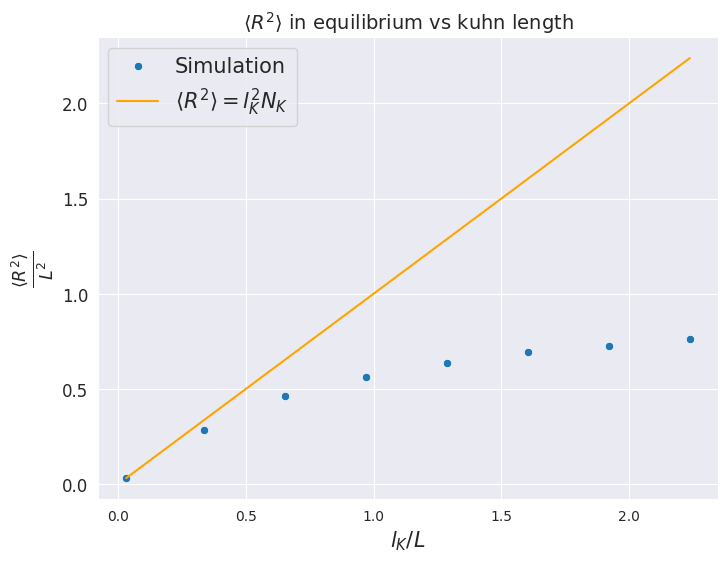

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    x=df_kuhn_summary["l_K"] / L_contour,
    y=df_kuhn_summary["R^2"] / L_contour ** 2,
    ax=ax,
    label="Simulation"
)

sns.lineplot(
    x=df_kuhn_summary["l_K"] / L_contour,
    y=(df_kuhn_summary["l_K"] ** 2 * N_Ks) / L_contour ** 2,
    label=r"$\langle R^2 \rangle = l_K^2 N_K$",
    color="orange"
)

ax.set(
    title=r"$\langle R^2 \rangle$ in equilibrium vs kuhn length",
    xlabel="$l_K / L$",
    ylabel=r"$\frac{\langle R^2 \rangle}{L^2}$"
)

ax.legend(fontsize=15)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(18)

In [35]:
df_kuhn_summary["l_K"] ** 2 * df_kuhn_summary["N_K"] / df_kuhn_summary["R^2"]

kappa
1.0     0.999067
11.0    1.180533
21.0    1.411828
31.0    1.722299
41.0    2.026079
51.0    2.311605
61.0    2.647925
71.0    2.937812
dtype: float64

### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [36]:
import polyflexmd.data_analysis.transform.msd as msd

In [37]:
PATH_MSD = PATH_DATA_PROCESSED / "msd.csv"
PATH_MSD

PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K/4-FENE-beadspring-vary-l_K/538accb2/data/processed/msd.csv')

In [38]:
if PATH_MSD.exists():
    df_msd = pd.read_csv(PATH_MSD, index_col="t")
else:
    df_msd = msd.calculate_msd_df(df_ete, ["kappa"])
    df_msd["t/LJ"] = df_msd.index.map(lambda t: t * 0.0025)
    df_msd["t/LJ"] = df_msd["t/LJ"] - df_msd["t/LJ"].min()
    df_msd["l_K"] = kremer_grest.bare_kuhn_length(df_msd["kappa"], l_b=l_b)
df_msd

dR^2  delta dR^2  kappa      t/LJ         l_K
t                                                             
30000000     0.000000    0.000000    1.0      0.00    1.854017
30000100     0.131123    0.015256    1.0      0.25    1.854017
30000200     0.469626    0.050481    1.0      0.50    1.854017
30000300     0.925409    0.098095    1.0      0.75    1.854017
30000400     1.451558    0.156999    1.0      1.00    1.854017
...               ...         ...    ...       ...         ...
64960000  2170.061793  235.428868   71.0  87400.00  136.770000
64970000  2165.468234  236.485894   71.0  87425.00  136.770000
64980000  2169.143304  236.389463   71.0  87450.00  136.770000
64990000  2167.883654  235.034069   71.0  87475.00  136.770000
65000000  2192.788809  234.926677   71.0  87500.00  136.770000

[186408 rows x 5 columns]

<Axes: title={'center': 'Empirical $ \\sqrt {\\langle (\\Delta R(t))^2 \\rangle} $ for different kuhn lengths $l_K$;\n$N_b=64;$$\\zeta_e=\\zeta=1.0$'}, xlabel='t / step', ylabel='distance / L'>

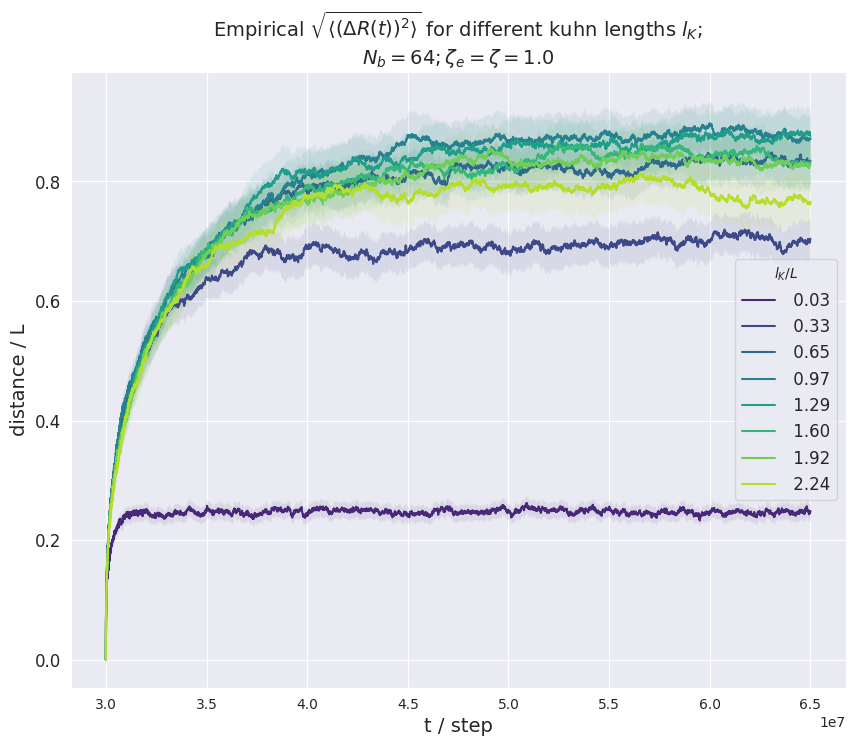

In [39]:
def plot_msd(df: pd.DataFrame, time_col: str = "t", time_label="t / step", log_scale: bool = False):
    df = df.reset_index()
    ax: plt.Axes
    fig: plt.Figure
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set(
        title=f'Empirical $ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$;\n'
              f'$N_b={conf.initial_system_config.system_config.n_monomers};$'
              f'$\zeta_e=\zeta=1.0$',
        ylabel="distance / L",
        xlabel=time_label
    )

    for i, (kappa, df_kappa) in enumerate(df.groupby("kappa")):
        y = np.sqrt(df_kappa["dR^2"]) / L_contour
        dy = df_kappa["delta dR^2"] / (np.sqrt(df_kappa["dR^2"]) * L_contour * 2)
        ax.plot(
            df_kappa[time_col],
            y,
            c=kappa_colors[i],
            label=f"{kremer_grest.bare_kuhn_length(kappa, l_b) / L_contour : .2f}",
            #path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()]
        )
        ax.fill_between(
            x=df_kappa[time_col],
            y1=y - dy,
            y2=y + dy,
            color=kappa_colors[i],
            alpha=.1,
            linewidth=0
        )

    ax.legend()
    ax.get_legend().set_title("$l_K/L$")
    if log_scale:
        ax.set(xscale="log", yscale="log")
    return ax


plot_msd(df_msd)

## Explore MSD

### Loglog scale

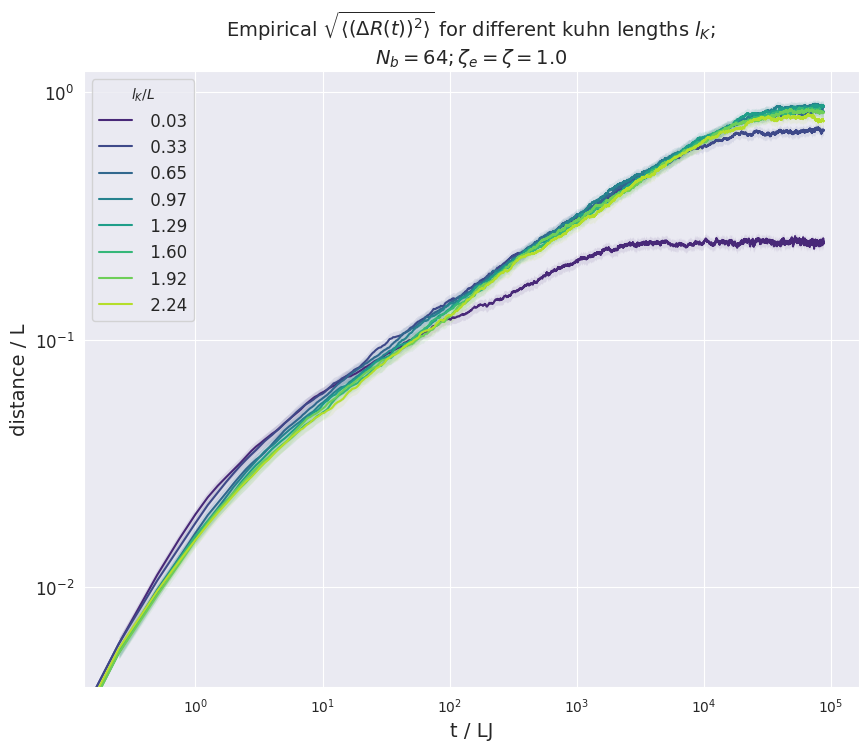

In [40]:
ax = plot_msd(df_msd, time_col="t/LJ", time_label="t / LJ", log_scale=True)
_ = ax.set(
    yscale="log",
    xscale="log",
    title=f'Empirical $ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$;\n'
          f'$N_b={conf.initial_system_config.system_config.n_monomers};$'
          f'$\zeta_e=\zeta=1.0$',
)

## Research different dimensions of MSD

In [45]:
PATH_ETE_MAIN_AX = PATH_DATA_PROCESSED / "ete_main_ax.csv"

if PATH_ETE_MAIN_AX.exists():
    print("Reading ...")
    df_ete_main_ax_frame = pd.read_csv(PATH_ETE_MAIN_AX, index_col="t")
else:
    print("Processing ...")
    df_ete_main_ax_frame = transform.change_basis_df_ete(df_ete, df_main_axis)
    df_ete_main_ax_frame.to_csv(PATH_ETE_MAIN_AX, index=True)

df_ete_main_ax_frame

Reading ...


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
df_msd_by_dim = msd.calculate_msd_by_dimension_df(
    df_ete=df_ete_main_ax_frame,
    group_by_params=["kappa"]
)
df_msd_by_dim["t/LJ"] = df_msd_by_dim.index.get_level_values("t").map(lambda t: t * 0.0025)
df_msd_by_dim["t/LJ"] = df_msd_by_dim["t/LJ"] - df_msd_by_dim["t/LJ"].min()
df_msd_by_dim

### Different dimensions of same $l_K$

In [ ]:
import matplotlib.transforms as mtransforms

fig: plt.Figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(2 * len(kappas), 8), sharex="all", sharey="all",
                        layout="constrained")
axs = axs.flatten()
dimensions = ["x", "y", "z"]

for (kappa, df_g), ax in zip(df_msd_by_dim.groupby("kappa"), axs.flat):
    for dim in dimensions:
        l_K = kremer_grest.bare_kuhn_length(kappa, l_b) / L_contour
        y = np.sqrt(df_g[f"dR_{dim}^2"]) / L_contour
        dy = df_g[f"delta dR_{dim}^2"] / (np.sqrt(df_g[f"dR_{dim}^2"]) * L_contour * 2)
        label = f"$l_K / L = {l_K : .2f}$"
        trans = mtransforms.ScaledTranslation(5 / 72, -5 / 72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='top',
                bbox=dict(facecolor='0.8', edgecolor='0.9'))
        ax.plot(
            df_g["t/LJ"],
            y,
            label=dim,
            #path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()]
        )
        ax.fill_between(
            x=df_g["t/LJ"],
            y1=y - dy,
            y2=y + dy,
            alpha=.2,
            linewidth=0
        )
        ax.legend().set_visible(False)

fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.06))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
fig.suptitle(f"MSD for different dimensions; z || 1. bond; $\zeta_e = \zeta = 1.0$; L = {L_contour : .2f}")

### Different $l_K$s of same dimension

In [ ]:
fig: plt.Figure
fig, axs = plt.subplots(ncols=len(dimensions), nrows=1, figsize=(18, 5), sharey="all")
axs = axs.flatten()


def _plot(ax, dim):
    for i, (kappa, df_kappa) in enumerate(df_msd_by_dim.groupby("kappa")):
        y = np.sqrt(df_kappa[f"dR_{dim}^2"]) / L_contour
        dy = df_kappa[f"delta dR_{dim}^2"] / (np.sqrt(df_kappa["dR^2"]) * L_contour * 2)
        l_K = kremer_grest.bare_kuhn_length(kappa, l_b) / L_contour
        ax.plot(
            df_kappa["t/LJ"],
            y,
            c=kappa_colors[i],
            label=f"$l_K/L = {l_K : .2f}$",
            linewidth=.9
        )
        ax.fill_between(
            x=df_kappa["t/LJ"],
            y1=y - dy,
            y2=y + dy,
            color=kappa_colors[i],
            alpha=.3,
            linewidth=0
        )

    ax.set(ylabel="distance/L", title=f"MSD {dim}")


for dim, ax in zip(dimensions, axs):
    _plot(ax, dim)

_ = fig.legend(*axs[-1].get_legend_handles_labels(), ncol=8, loc='lower center', bbox_to_anchor=(0.5, -0.06))


## Compare with Rouse model


### Analytical $\tau_R$

Svaneborg (15)

Rouse relaxation time:
$$ \tau_R = \frac{1}{3 \pi^2} \frac{\zeta_K N_K l_K^2}{k_B T} = \frac{1}{3 \pi^2} \frac{\zeta N_b N_K l_K^2}{k_B T}$$
Relaxation time of single bead:
$$ \tau_0 = \frac{3 \pi^2 \tau_R}{N_K^2} $$

In [46]:
zeta = 1  # LJ
T = 1
k_B = 1
alpha = 4.047

rouse_times_analytical = []
for i, (l_K, N_K, R_sq) in enumerate(zip(df_kuhn_summary["l_K"], df_kuhn_summary["N_K"], df_kuhn_summary["R^2"])):
    tau_R_analytical = zeta * conf.initial_system_config.system_config.n_monomers * N_K * l_K ** 2 / (
            3 * np.pi ** 2 * k_B * T)
    tau_R_analytical_corrected = tau_R_analytical * alpha
    rouse_times_analytical.append(tau_R_analytical_corrected)

df_rouse_times_theory = pd.DataFrame({
    "l_K": df_kuhn_summary["l_K"],
    "N_K": df_kuhn_summary["N_K"],
    "Theory tau_R": rouse_times_analytical,
    "Theory tau_0": rouse_times_analytical / df_kuhn_summary["N_K"] ** 2
}, index=df_kuhn_summary.index)

df_rouse_times_theory

l_K        N_K  Theory tau_R   Theory tau_0
kappa                                                    
1.0      1.854017  32.960864    991.101568       0.912265
11.0    20.370000   3.000000  10889.187947    1209.909787
21.0    39.770000   1.536585  21259.842998    9004.231816
31.0    59.170000   1.032787  31630.498119   29654.090073
41.0    78.570000   0.777778  42001.153240   69430.477805
51.0    97.970000   0.623762  52371.808361  134604.388281
61.0   117.370000   0.520661  62742.463482  231446.814774
71.0   136.770000   0.446809  73113.118603  366228.750552

Text(0.5, 0.98, 'Comparison empirical MSD with Rouse model for different kuhn lengths $l_K$; $\\zeta_e = \\zeta = 1.0$; L =  61.11')

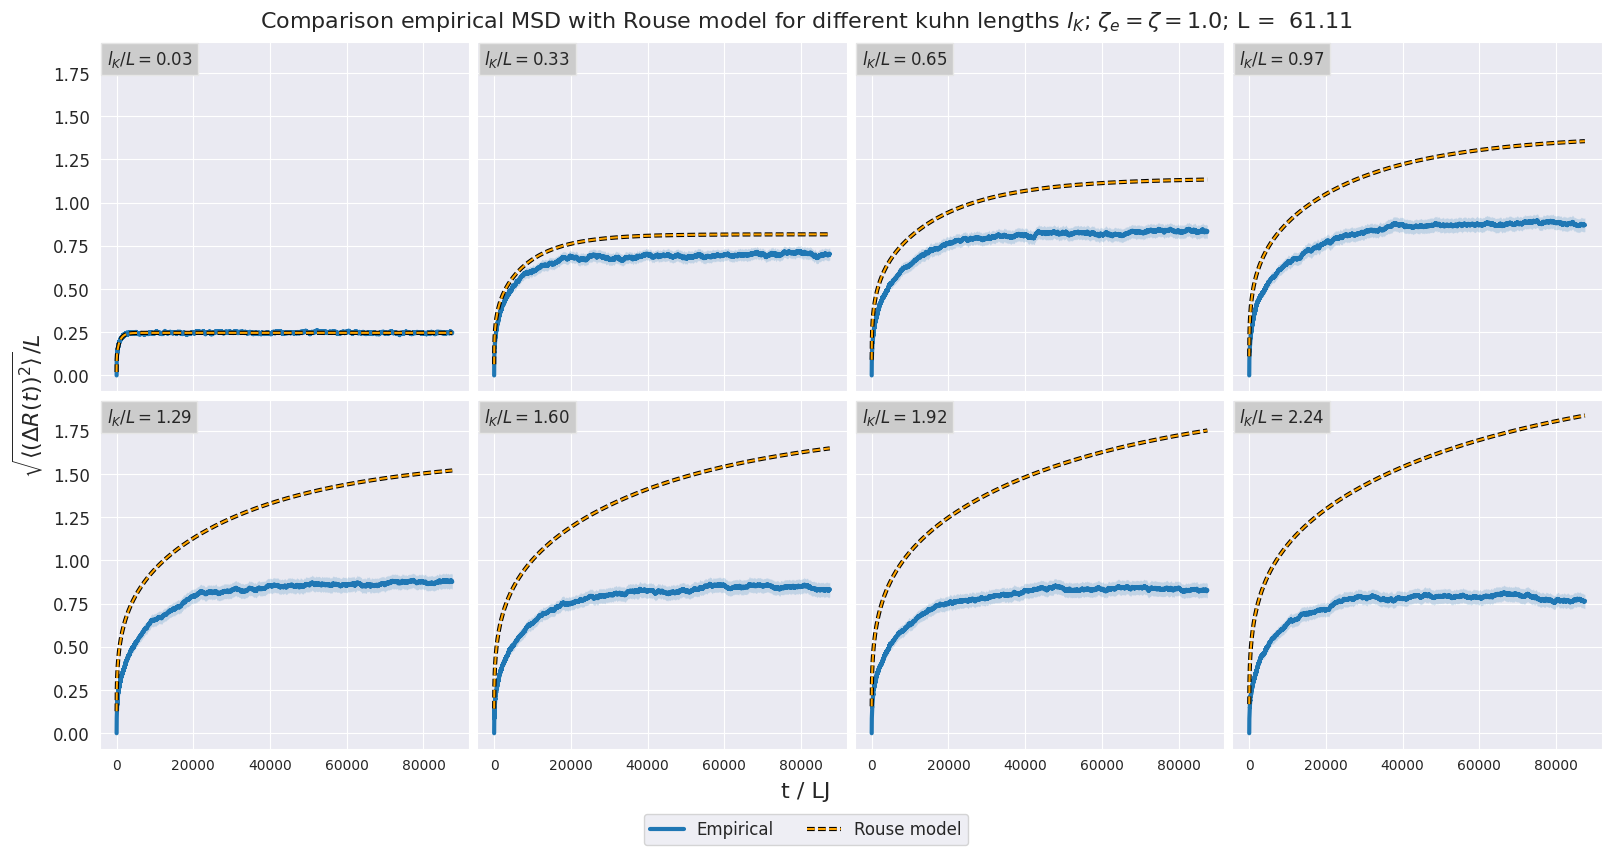

In [106]:
import matplotlib.patheffects as pe

fig: plt.Figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(2 * len(kappas), 8), sharex="all", sharey="all",
                        layout="constrained")
axs = axs.flatten()

for i, (kappa, df_g) in enumerate(df_msd.groupby("kappa")):
    ax = axs[i]
    l_K = kremer_grest.bare_kuhn_length(kappa, l_b) / L_contour
    y = np.sqrt(df_g[f"dR^2"]) / L_contour
    dy = df_g[f"delta dR^2"] / (np.sqrt(df_g[f"dR^2"]) * L_contour * 2)
    label = f"$l_K / L = {l_K : .2f}$"
    trans = matplotlib.transforms.ScaledTranslation(5 / 72, -5 / 72, fig.dpi_scale_trans)

    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='0.9'))

    ax.plot(
        df_g["t/LJ"],
        y,
        label="Empirical",
        linewidth=3
    )

    ax.fill_between(
        x=df_g["t/LJ"],
        y1=y - dy,
        y2=y + dy,
        alpha=.2,
        linewidth=0
    )

    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_theory.loc[kappa]["Theory tau_R"]

    rouse_predictions = rouse.rouse_g_4(
        t=df_g["t/LJ"],
        tau_R=tau_R,
        p_max=conf.initial_system_config.system_config.n_monomers,
        N_b=N_K,
        l_b=l_K * L_contour
    )

    ax.plot(
        df_g["t/LJ"],
        np.sqrt(rouse_predictions) / L_contour,
        linestyle="dashed",
        path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()],
        label="Rouse model",
        color="orange",
    )

    ax.legend().set_visible(False)

fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.06))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
fig.suptitle(
    f"Comparison empirical MSD with Rouse model for different kuhn lengths $l_K$; $\zeta_e = \zeta = 1.0$; L = {L_contour : .2f}")

### Fit $\tau_R$

In [84]:

df_rouse_times_fit = []

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_msd.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(rouse.rouse_g_4, N_b=N_K, l_b=l_K, p_max=conf.initial_system_config.system_config.n_monomers),
        df_ete_change_kappas_equi_kappa.loc[df_ete_change_kappas_equi_kappa["t/LJ"] < 1e4]["t/LJ"],
        df_ete_change_kappas_equi_kappa[df_ete_change_kappas_equi_kappa["t/LJ"] < 1e4]["dR^2"],
        p0=(10 ** (i + 1),) if i != 0 else 100
    )
    df_rouse_times_fit.append((kappa, popt[0], np.sqrt(np.diag(pcov))[0], l_K, N_K))

df_rouse_times_fit = pd.DataFrame(
    df_rouse_times_fit,
    columns=["kappa", "Empirical tau_R", "Empirical Delta tau_R", "l_K", "N_K"]
).set_index("kappa")

df_rouse_times_fit["Empirical tau_0"] = df_rouse_times_fit["Empirical tau_R"] / df_rouse_times_fit["N_K"] ** 2
df_rouse_times_fit["Empirical Delta tau_0"] = df_rouse_times_fit["Empirical Delta tau_R"] / df_rouse_times_fit[
    "N_K"] ** 2

df_rouse_times_fit

Empirical tau_R  Empirical Delta tau_R         l_K        N_K  \
kappa                                                                  
1.0         953.318324               0.719159    1.854017  32.960864   
11.0      17978.154608              15.117218   20.370000   3.000000   
21.0      61946.513031              63.345018   39.770000   1.536585   
31.0     130929.255556             123.814540   59.170000   1.032787   
41.0     264613.191612             333.798881   78.570000   0.777778   
51.0     445213.323751             527.801071   97.970000   0.623762   
61.0     640515.582079             755.887583  117.370000   0.520661   
71.0     903600.632731            1224.359624  136.770000   0.446809   

       Empirical tau_0  Empirical Delta tau_0  
kappa                                          
1.0       8.774872e-01               0.000662  
11.0      1.997573e+03               1.679691  
21.0      2.623635e+04              26.828666  
31.0      1.227482e+05             116.078081  
41.0      4.374218e+05             551.789987  
51.0      1.144273e+06            1356.537849  
61.0      2.362759e+06            2788.347215  
71.0      4.526199e+06            6132.903424

Text(0.5, 0.98, 'MSD: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; $\\zeta_e = \\zeta = 1.0$; L= 61.11')

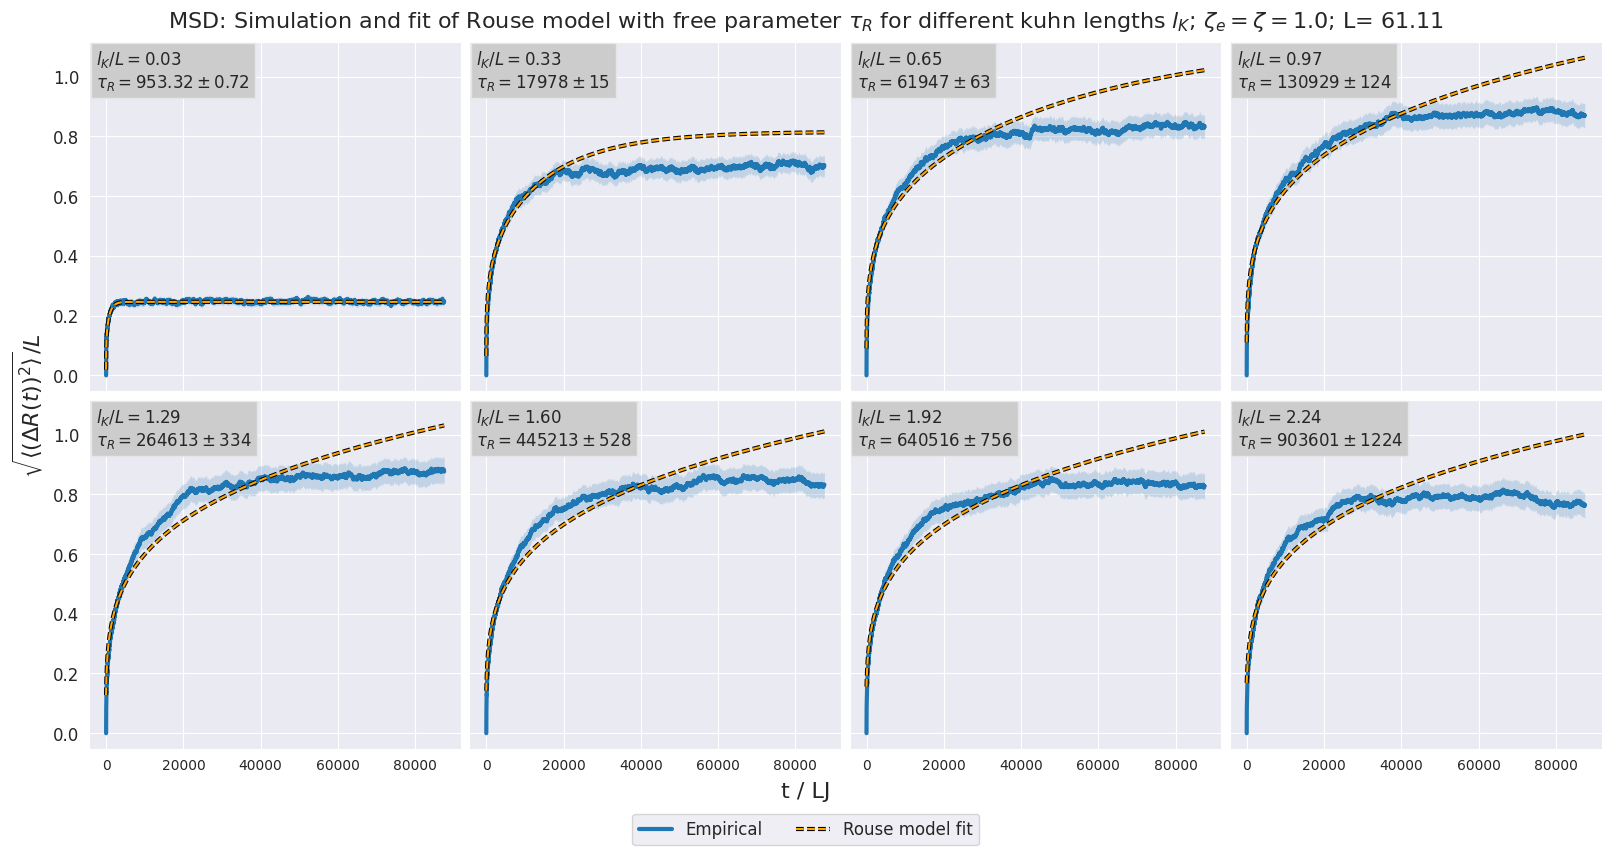

In [105]:
fig: plt.Figure
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(2 * len(kappas), 8), sharex="all", sharey="all",
                        layout="constrained")
axs = axs.flatten()

for i, (kappa, df_g) in enumerate(df_msd.groupby("kappa")):

    ax = axs[i]
    l_K = kremer_grest.bare_kuhn_length(kappa, l_b)
    y = np.sqrt(df_g[f"dR^2"]) / L_contour
    dy = df_g[f"delta dR^2"] / (np.sqrt(df_g[f"dR^2"]) * L_contour * 2)

    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    tau_R = df_rouse_times_fit.loc[kappa]["Empirical tau_R"]
    dtau_R = df_rouse_times_fit.loc[kappa]["Empirical Delta tau_R"]

    if dtau_R >= 1.0:
        tau_R = round(tau_R)
        dtau_R = round(dtau_R)
        tau_label = f"$\\tau_R = {tau_R} \pm {dtau_R}$"
    else:
        tau_label = f"$\\tau_R = {tau_R:.2f} \pm {dtau_R:.2f}$"

    label = f"$l_K / L = {l_K / L_contour : .2f}$\n{tau_label}"
    trans = matplotlib.transforms.ScaledTranslation(5 / 72, -5 / 72, fig.dpi_scale_trans)

    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top',
            bbox=dict(facecolor='0.8', edgecolor='0.9'))

    ax.plot(
        df_g["t/LJ"],
        y,
        label="Empirical",
        linewidth=3
    )

    ax.fill_between(
        x=df_g["t/LJ"],
        y1=y - dy,
        y2=y + dy,
        alpha=.2,
        linewidth=0
    )

    rouse_fit = rouse.rouse_g_4(
        t=df_g["t/LJ"],
        N_b=N_K,
        l_b=l_K,
        p_max=conf.initial_system_config.system_config.n_monomers,
        tau_R=tau_R
    )

    ax.plot(
        df_g["t/LJ"],
        np.sqrt(rouse_fit) / L_contour,
        label=f"Rouse model fit",
        path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()],
        color="orange",
        linestyle="--"
    )

    ax.legend().set_visible(False)

fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.06))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
fig.suptitle(
    f"MSD: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; $\zeta_e = \zeta = 1.0$; L={L_contour : .2f}")

### Compare times

In [94]:
df_rouse_rimes = df_rouse_times_theory.join(df_rouse_times_fit.drop(["l_K", "N_K"], axis=1))
df_rouse_rimes

l_K        N_K  Theory tau_R   Theory tau_0  Empirical tau_R  \
kappa                                                                        
1.0      1.854017  32.960864    991.101568       0.912265       953.318324   
11.0    20.370000   3.000000  10889.187947    1209.909787     17978.154608   
21.0    39.770000   1.536585  21259.842998    9004.231816     61946.513031   
31.0    59.170000   1.032787  31630.498119   29654.090073    130929.255556   
41.0    78.570000   0.777778  42001.153240   69430.477805    264613.191612   
51.0    97.970000   0.623762  52371.808361  134604.388281    445213.323751   
61.0   117.370000   0.520661  62742.463482  231446.814774    640515.582079   
71.0   136.770000   0.446809  73113.118603  366228.750552    903600.632731   

       Empirical Delta tau_R  Empirical tau_0  Empirical Delta tau_0  
kappa                                                                 
1.0                 0.719159     8.774872e-01               0.000662  
11.0               15.117218     1.997573e+03               1.679691  
21.0               63.345018     2.623635e+04              26.828666  
31.0              123.814540     1.227482e+05             116.078081  
41.0              333.798881     4.374218e+05             551.789987  
51.0              527.801071     1.144273e+06            1356.537849  
61.0              755.887583     2.362759e+06            2788.347215  
71.0             1224.359624     4.526199e+06            6132.903424

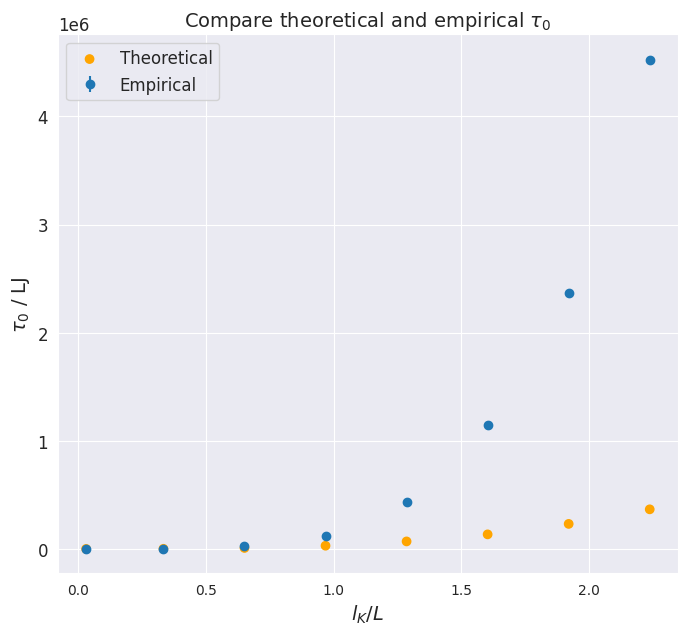

In [95]:
import matplotlib.container
import matplotlib.collections

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8, 7))

errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\tau_0$ / LJ",
    title="Compare theoretical and empirical $\\tau_0$"
)

path_coll: matplotlib.collections.PathCollection = ax.scatter(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Theory tau_0"],
    linestyle="",
    marker="o",
    label="Theoretical",
    color="orange",
)

ax.legend()

[Text(0.5, 0, '$l_K/L$'),
 Text(0, 0.5, '$\\Delta \\tau_0$ / LJ'),
 Text(0.5, 1.0, 'Empirical $\\tau_0$ - Theoretical $\\tau_0$')]

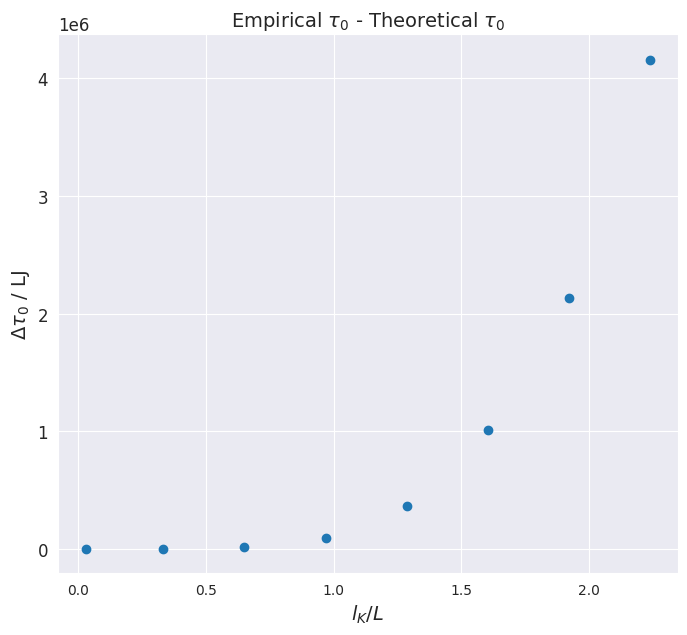

In [96]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(8, 7))

errorbar_container: matplotlib.container.ErrorbarContainer = ax.errorbar(
    x=df_rouse_rimes["l_K"] / L_contour,
    y=df_rouse_rimes["Empirical tau_0"] - df_rouse_rimes["Theory tau_0"],
    yerr=df_rouse_rimes["Empirical Delta tau_0"],
    linestyle="",
    marker="o",
    label="Empirical - Theory",
)

ax.set(
    xlabel="$l_K/L$",
    ylabel="$\\Delta \\tau_0$ / LJ",
    title="Empirical $\\tau_0$ - Theoretical $\\tau_0$"
)

In [97]:
import plotly

plotly.offline.init_notebook_mode(connected=False)